# Scalable Graph Learning

GCN and GAT, although fantastic designs, have two issues:
- scaling to large graphs 
- inefficiently in generalizing to unseen data

Traditional GCNs are designed to process the **entire** graph simultaneously during training and inference. This approach is known as full-batch training. Moreover, GCNs operate on the adjacency matrix $𝐴$ and the feature matrix $X$ of the entire graph. 

GraphSAGE (Graph Sample and Aggregate) addresses the scalability issues of GCNs by introducing a method to perform mini-batch training on graphs. By *sampling neighbors* and constructing *mini-batches*, GraphSAGE allows for efficient training on large graphs. This method significantly reduces memory usage and computational cost.

#### Constructing mini-batches

Graph Convolutional Networks (GCNs) generate embeddings for *all* nodes in the graph simultaneously. To achieve this, GCNs load the entire adjacency matrix $A$ and the node feature matrix $X$. At each layer of the network, GCNs compute the embeddings of all nodes by aggregating the embeddings from the previous layer. This process continues layer by layer until the final layer, where the model computes the loss and performs *full-batch* gradient descent to update the weights.

However, full-batch implementation is not feasible for large graphs due to several limitations. One primary issue is the constrained memory capacity of GPUs, which we utilize for accelerated training. Since GPU memory is limited, it becomes impractical to load the entire graph structure and all node features into GPU memory simultaneously. This limitation necessitates alternative approaches to handle large-scale graphs efficiently.

<u>**Key insight: To compute embedding of a single node, all we need is the K-hop neighborhood**</u>

Instead of processing the entire graph at once, GraphSAGE proposes to select mini-batches of M nodes from the graph for training. These are the target nodes for which embeddings will be computed. Given a set of M different nodes in a mini-batch, we can generate each node's embeddings using a smaller subgraph which involves neighbors up to K-hops away.


<div style="display: flex; align-items: flex-end;">
    <div style="flex: 1; padding: 5px;">
        <img src="images/2hops.png" alt="Image 1" style="max-width: 100%;">
        <p style="text-align: center;">1-hop and 2-hop neighbors of node 0</p>
    </div>
    <div style="flex: 1; padding: 5px;">
        <img src="images/2hopes_cg.png" alt="Image 2" style="max-width: 100%;">
        <p style="text-align: center;">A computation graph for node 0</p>
    </div>
</div>
<center><small>images from https://web.stanford.edu/class/cs224w/slides/15-scalable.pdf</small></center>

However, the computations can become exponentially large with respect to the layer size K (depicted in Figure a) or explodes when it hits a hub node (high-degree node, such as celebrities with lots of followers in social networks).
<center><img src="images/issue_naive_minibatch.png" width="400"> </center>
<center><small>images from https://web.stanford.edu/class/cs224w/slides/15-scalable.pdf</small></center>

We have to make each subgraph more *"compact"*. Sample a **fixed number of neighbors** for each node. This sampling is performed layer by layer, ensuring that the computation remains manageable.

<center><img src="images/2hop_sampling.png" width=500></center>
<center><small>neighbor sampling to keep two 1-hop neighbors and two 2-hop neighbors</small></center>

GraphSAGE aggregates information from the sampled neighbors using functions like mean, LSTM, or pooling. The aggregation ensures that the representation of each node is influenced by its local neighborhood.

\begin{equation*}
h^k_{\mathcal{N}(v)} \leftarrow AGGREGATE_k\left(\{h_u^{k-1}, \forall u \in \mathcal{N}(v)\}\right)
\end{equation*}

- Aggregation using mean: taking the mean of the node’s own features and its neighbors' features, followed by a linear transformation and non-linear activation.
\begin{equation*}
h_v^k \leftarrow \sigma(W\cdot MEAN \left( \{h_v^{k-1}\} \cup \{h_u^{k-1} \forall u \in \mathcal{N}(v)\}\right))
\end{equation*}
- Aggregation using LSTM: In a graph, a node's neighbors do not have an inherent order. This poses a challenge for LSTMs, which are designed to process sequences of data where order is important. To apply LSTMs in this context, we treat the neighbors of a node as a sequence by randomly permuting the set of neighbors. Each neighbor's feature vector is fed into the LSTM in this random order. Once the neighbors are randomly ordered, the LSTM processes the sequence. The hidden state of the LSTM is updated as it processes each neighbor’s feature vector in the sequence.

\begin{equation*}
h_v^k \leftarrow \sigma(W\cdot \left[h_v^{k-1} || h_{\mathcal{N}(v)}^{k-1}\right] )
\end{equation*}
<div style="margin-left: 40px;">
where $[||]$ denotes concatenation and ${\mathcal{N}(v)}^{k-1}$ is the final hidden state of LSTM after processing all neighbors (in random order).
</div>

- Aggregation using pooling: Instead of using simple statistical functions like mean or sophisticated sequential models like LSTMs, the pooling aggregator applies a neural network to each neighbor's feature vector and then aggregates the transformed features using an element-wise pooling operation (e.g., max or mean pooling).
    - Apply a neural network MLP to each neighbor’s feature vector and Aggregate the transformed neighbor features using an element-wise pooling operation such as max pooling:
    \begin{equation*}
    {\mathcal{N}(v)}^{k-1} = max(\{MLP(h_u^{k-1})|u\in \mathcal{N}_v\})
    \end{equation*}
    - Combine the node’s own embedding with the aggregated neighbor representation:
    \begin{equation*}
h_v^k \leftarrow \sigma(W\cdot \left[h_v^{k-1} || h_{\mathcal{N}(v)}^{k-1}\right] )
\end{equation*}


## Illustration of GraphSAGE Sampling in Python

Suppose we have a graph with nine nodes and eleven edges. Each node has a corresponding feature vector of size 3. Five nodes (A, C, E, G, I) are randomly labeled for the training set.

The sampling process to create mini-batches is typically carried out using the `NeighborLoader` function in PyTorch Geometric. This function takes several important parameters: 

1. **PyTorch Geometric Data object:** Contains features, labels, and graph structure.
2. **Number of neighbors to sample for each node:** If an integer is provided, it specifies the number of neighbors to sample at each layer of the graph. If a list is provided, it specifies the number of neighbors to sample at each layer hierarchically.
3. **Mini-batch size:** Determines how many nodes are processed at a time.
4. **Shuffle:** Indicates whether to shuffle the nodes in each epoch. Shuffling can help with training by ensuring the model does not see the same order of nodes repeatedly.

Suppose we set the batch size to 2 and the number of neighbors to sample for each layer to [2, 2]. The `NeighborLoader` will divide the training nodes (A, C, E, G, I) into three batches with two nodes each (except the final mini-batch): {{A, C}, {E, G}, {I}}. The sampling for two layers for each of the three batches is illustrated in the following code:


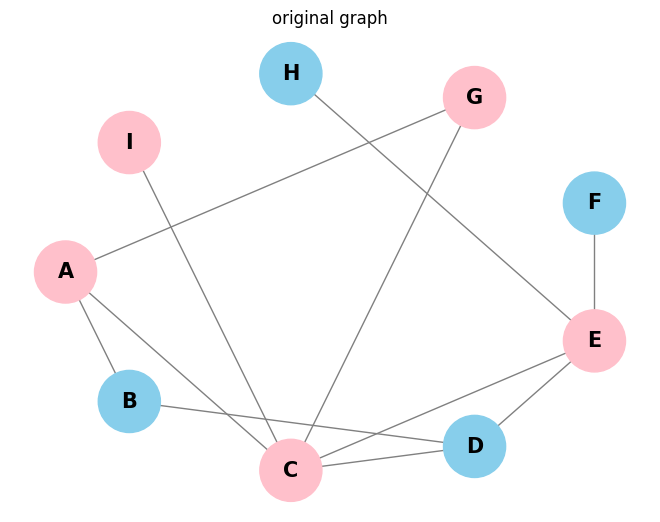

Subgraph 0 input nodes: ['A', 'C']
Subgraph 0 all nodes: ['A', 'C', 'B', 'G', 'D', 'I', 'E']
Subgraph 0 nodes: ['A', 'C', 'B', 'G', 'D', 'I', 'E']
Subgraph 0 edges: [('B', 'A'), ('G', 'A'), ('D', 'C'), ('I', 'C'), ('A', 'B'), ('D', 'B'), ('A', 'G'), ('C', 'G'), ('B', 'D'), ('E', 'D'), ('C', 'I')]
Subgraph 1 input nodes: ['E', 'G']
Subgraph 1 all nodes: ['E', 'G', 'D', 'F', 'A', 'C', 'B']
Subgraph 1 nodes: ['E', 'G', 'D', 'F', 'A', 'C', 'B']
Subgraph 1 edges: [('D', 'E'), ('F', 'E'), ('A', 'G'), ('C', 'G'), ('B', 'D'), ('E', 'D'), ('E', 'F'), ('B', 'A'), ('G', 'A'), ('D', 'C'), ('E', 'C')]
Subgraph 2 input nodes: ['I']
Subgraph 2 all nodes: ['I', 'C', 'A']
Subgraph 2 nodes: ['I', 'C', 'A']
Subgraph 2 edges: [('C', 'I'), ('A', 'C'), ('I', 'C')]


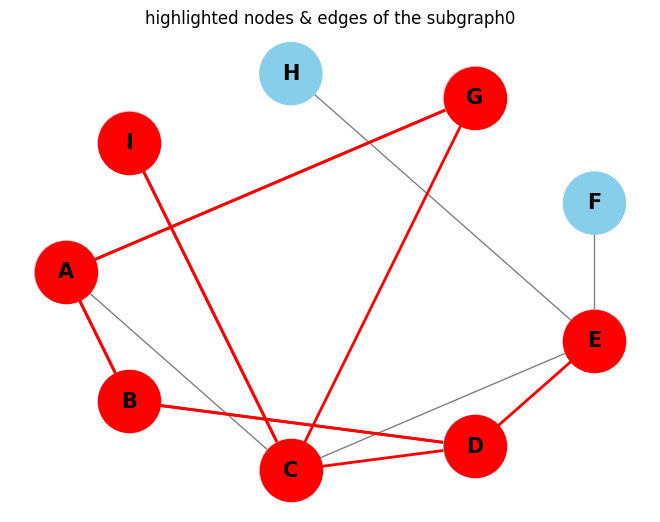

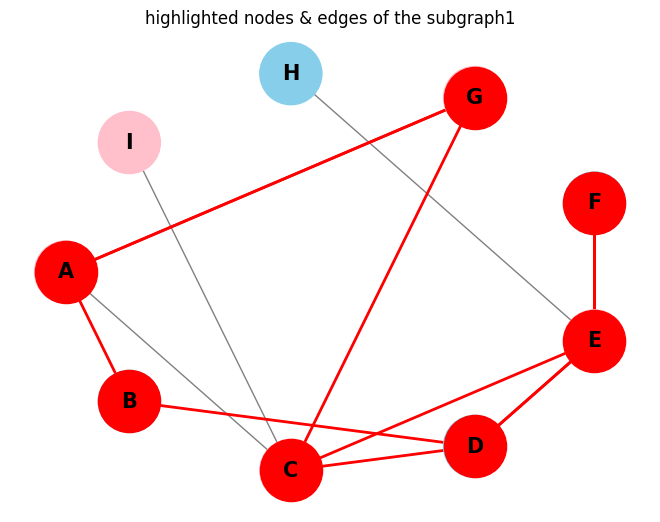

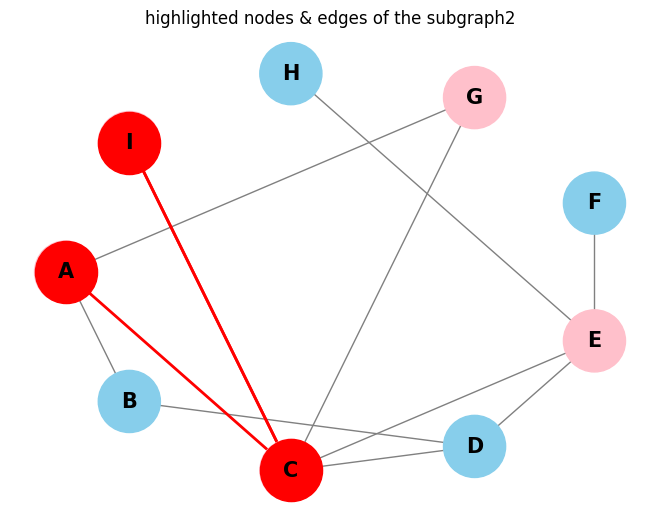

In [108]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.loader import NeighborLoader

# Define the graph structure
nodes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
edges = [('A', 'B'), ('A', 'C'), ('B', 'D'), ('C', 'D'), ('C', 'E'), ('D', 'E'), ('E', 'F'), ('G', 'A'), ('G', 'C'), ('H', 'E'), ('I', 'C')]

# Create a NetworkX undirected graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Assign random features, labels, and train_mask to nodes
features = {node: np.random.rand(3) for node in nodes}
labels = {node: np.random.randint(2) for node in nodes}
train_mask = {node: idx % 2 == 0 for idx, node in enumerate(nodes)}

# Add attributes to the graph
nx.set_node_attributes(G, features, 'x')
nx.set_node_attributes(G, labels, 'y')
nx.set_node_attributes(G, train_mask, 'train_mask')

# Convert NetworkX graph to PyTorch Geometric Data object
data = from_networkx(G)

train_loader = NeighborLoader(
    data,
    num_neighbors=[2, 2],
    batch_size=2,
    input_nodes=data.train_mask,
    shuffle=False
)

# Function to visualize a graph
def visualize_graph(G, subgraph_edges=None, subgraph_nodes=None):
    fig = plt.figure()
    pos = nx.shell_layout(G)
    train_mask_color = ['pink' if G.nodes[node]['train_mask'] else 'skyblue' for node in G.nodes]
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color=train_mask_color, font_size=15, font_weight='bold', edge_color='gray')

    if subgraph_edges:
        nx.draw_networkx_edges(G, pos, edgelist=subgraph_edges, edge_color='red', width=2)
    if subgraph_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=subgraph_nodes, node_color='red', node_size=2000)

# Visualize the main graph
visualize_graph(G)
plt.title('original graph')
plt.show()
# Visualize subgraphs from the DataLoader
node_mapping = {i: node for i, node in enumerate(nodes)}

for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i} input nodes: {[node_mapping[node.item()] for node in subgraph.input_id]}')
    print(f'Subgraph {i} all nodes: {[node_mapping[node.item()] for node in subgraph.n_id]}')

    # Convert subgraph edge_index to original graph edges
    subgraph_edge_index = subgraph.edge_index.numpy()
    subgraph_edges = [(node_mapping[subgraph_edge_index[0, j]], node_mapping[subgraph_edge_index[1, j]]) for j in range(subgraph_edge_index.shape[1])]

    # Correctly map edges using n_id
    original_indices = subgraph.n_id.tolist()
    reverse_mapping = {idx: node_mapping[node] for idx, node in enumerate(original_indices)}
    subgraph_edges = [(reverse_mapping[src], reverse_mapping[dst]) for src, dst in zip(subgraph_edge_index[0], subgraph_edge_index[1])]

    # Convert subgraph node indices to original graph node names
    subgraph_nodes = [node_mapping[node.item()] for node in subgraph.n_id]

    print(f'Subgraph {i} nodes: {subgraph_nodes}')
    print(f'Subgraph {i} edges: {subgraph_edges}')
    
    # Visualize the subgraph on the original graph
    visualize_graph(G, subgraph_edges=subgraph_edges, subgraph_nodes=subgraph_nodes)
    plt.title(f'highlighted nodes & edges of the subgraph{i}')
